<a href="https://colab.research.google.com/github/Kristytiki/Neural-Network/blob/master/Project_1_PCA,_Antuencoder_and_FLD_for_Analyzing_Human_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
# Load dataset with 800 training image(800*128*128) and 200 testing image(200*128*128)
"""
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# read data
X_train = np.load("/content/drive/My Drive/Colab Notebooks/X_train.npy")
X_test = np.load("/content/drive/My Drive/Colab Notebooks/X_test.npy")

In [0]:

import numpy as np

#X_train = np.load('X_train.npy')
#X_train = X_train[:,:,:,2]
#X_test = np.load('X_test.npy')
#X_test = X_test[:,:,:,2]



In [95]:
X_train.shape

(800, 128, 128, 3)

# 2.1.1
## 1. Display the first 10 eigen-faces

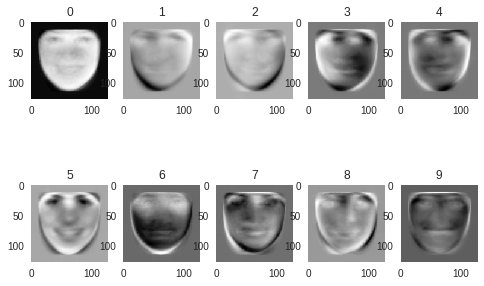

In [225]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X_train = X_train[:,:,:,2]
X_test = X_test[:,:,:,2]

n,p = X_train.shape[0:2]
k = 50
# get the mean faces
X = np.reshape(X_train,(n,-1))
m = np.mean(X, axis=0)
X_centered = X - np.mean(X, axis=0)
# use PCA to get eigenvector
pca = decomposition.PCA(n_components=k)
X_transformed = pca.fit_transform(X_centered)
pca.components_1 = np.reshape(pca.components_,(k,p,p))

# show image
#plt.imshow(pca.components_1[0,:,:])
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(pca.components_1[i,:,:])
    ax.grid(False)
    plt.title(i)
#plt.savefig("imshow_4x4.png")



## 2. Plot 10 reconstruct faces and the corresponding original faces

In [0]:

p=128
T = 10
recons_10 = np.reshape(np.zeros(10*p*p),(10,p,p))
# choose first 10 image to reconstruct (use testing images) index = 10

n2 = 200
# faltten the matrix
X_test = np.reshape(X_test,(n2,-1))
X_test_centered = X_test - m
X_test_centered.shape

for j in range(10):
  b = np.reshape(np.zeros(T),(T,1))
  recons = np.reshape(np.zeros(p*p),(p,p))
  for i in range(T):
    b[i] = (np.reshape(X_test_centered[j,:],(p*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*p,1)))
    #print(b.shape)
    
    recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*p,1)),b[i]),(p,p)) + recons
    #print(recons)
  recons_10[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,p))

"""
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(recons_10[i,:,:])
    ax.grid(False)
    plt.title(i)
"""
# combine V channels with H.S
X_train = np.load("/content/drive/My Drive/Colab Notebooks/X_train.npy")
X_test = np.load("/content/drive/My Drive/Colab Notebooks/X_test.npy")
orginal_10 = X_test[0:10,:,:,:]
recon3_10 = np.reshape(np.zeros(10*p*p*3),(10,p,p,3))
for i in range(2):
  recon3_10[:,:,:,i] = orginal_10[:,:,:,i]
recon3_10[:,:,:,2] = recons_10[:,:,:]
from skimage.color import hsv2rgb
#orginal_10 = hsv2rgb(orginal_10)


In [285]:
# test 
"""
a = np.reshape(np.array([1,2,3,4,5,6]),(3,2))
b = np.reshape(np.array([1,1]),(2,1))
np.dot(a,b)
"""

array([[ 3],
       [ 7],
       [11]])

In [227]:
!pip install imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import datetime
import imageio
def plot(samples,Nh,Nc,channel,IMG_HEIGHT, IMG_WIDTH):
    fig = plt.figure(figsize=(Nc, Nh))
    plt.clf()
    gs = gridspec.GridSpec(Nh, Nc)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[0:Nh*Nc,:,:,:]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if channel==1:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH)
            immin=(image[:,:]).min()
            immax=(image[:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image,cmap ='gray')
        else:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH,channel)
            immin=(image[:,:,:]).min()
            immax=(image[:,:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image)
    return fig 
  


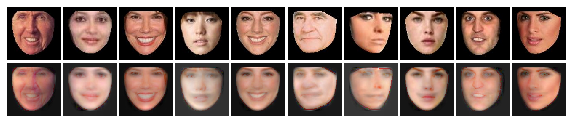

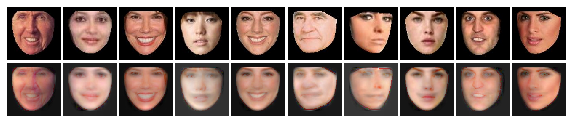

In [228]:
plot20 = np.reshape(np.zeros(20*p*p*3),(20,p,p,3))
"""
def scale_rgb(image):
    immin=(image[:,:,:]).min()
    immax=(image[:,:,:]).max()
    image=(image-immin)/(immax-immin+1e-8)
    return image
"""
for i in range(10):
    plot20[i,:,:,:] = hsv2rgb(orginal_10[i,:,:,:])
    plot20[10+i,:,:,:] = hsv2rgb(recon3_10[i,:,:,:])
    # rgb must in 0-1 range
    #plot20[10+i,:,:,:] = scale_rgb(plot20[10+i,:,:,:])
    
plot(plot20,2,10,3,128,128)

## 3. Plot the total reconstruction error per pixel over the number of eigen-faces K = 1,5,10,15,...,50

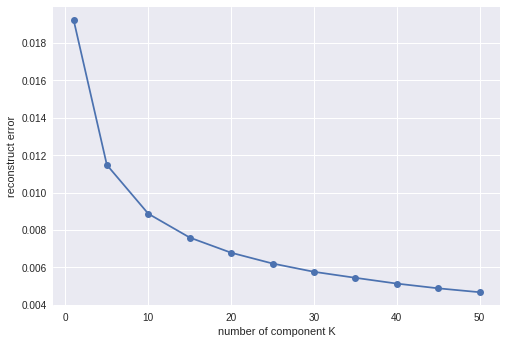

In [231]:
def recons(K,X_train,X_test):
    
    # get eigen-faces
    X_train = X_train[:,:,:,2]
    n,p = X_train.shape[0:2]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,p))
    
    
    # reconstruct test faces
    X_test = X_test[:,:,:,2]
    n2 = X_test.shape[0]
    recons_K = np.reshape(np.zeros(n2*p*p),(n2,p,p))
    X_test = np.reshape(X_test,(n2,-1))
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_centered.shape
    for j in range(n2):
        b = np.reshape(np.zeros(K),(K,1))
        recons = np.reshape(np.zeros(p*p),(p,p))
        for i in range(K):
            b[i] = (np.reshape(X_test_centered[j,:],(p*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*p,1)))
            #print(b.shape)
            recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*p,1)),b[i]),(p,p)) + recons
            
        #print(recons)
        recons_K[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,p))
    return(pca.components_1,recons_K)


def total_re_error(K,X_train,X_test):

    n2 = X_test.shape[0]
    p = X_test.shape[1]

    # compare reconstruction error using HSV images
    orgin_img = X_test


    _,test_1 = recons(K,X_train,X_test)
    """
    test_img = np.reshape(np.zeros(n2*p*p*3),(n2,p,p,3))
    for i in range(2):
         test_img[:,:,:,i] = orgin_img[:,:,:,i]
    test_img[:,:,:,2] = test_1[:,:,:]
    for i in range(n2):
        orgin_img[i,:,:,:] = hsv2rgb(orgin_img[i,:,:,:])
        test_img[i,:,:,:] = hsv2rgb(test_img[i,:,:,:])
    """
    orgin_img = orgin_img[:,:,:,2]
    test_img = test_1[:,:,:]
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum((orgin_img[i,:,:]-test_img[i,:,:])**2)/(p*p)
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(total_re_error(k,X_train,X_test))

    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.2 Landmarks
## 1. Display the first 10 eigen-warping and reconstruct the landmarks for the test faces.

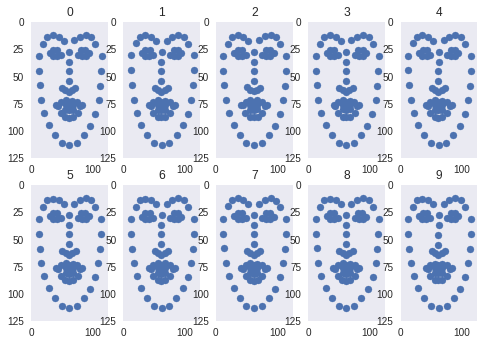

In [232]:
#upload mywarper.py and landmark.npy

import mywarper
mats = np.load('/content/drive/My Drive/Colab Notebooks/landmark.npy')
from sklearn.model_selection import train_test_split
m_train, m_test = train_test_split(mats,test_size=0.2)
m_train.shape
def m_recons(K,X_train,X_test):
    
    # get eigen-faces
    n,p,q = X_train.shape[0:3]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,q))
    
    
    # reconstruct test faces
    n2 = X_test.shape[0]
    recons_K = np.reshape(np.zeros(n2*p*q),(n2,p,q))
    X_test = np.reshape(X_test,(n2,-1))
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_centered.shape
    for j in range(n2):
        b = np.reshape(np.zeros(K),(K,1))
        recons = np.reshape(np.zeros(p*q),(p,q))
        for i in range(K):
            b[i] = (np.reshape(X_test_centered[j,:],(q*p,1)).T).dot(np.reshape(pca.components_1[i,:,:],(p*q,1)))
            #print(b.shape)
            recons = np.reshape(np.multiply(np.reshape(pca.components_1[i,:,:],(p*q,1)),b[i]),(p,q)) + recons
        #print(recons)
        recons_K[j,:,:] = recons + np.reshape(np.mean(X_test, axis=0),(p,q))

    return(np.mean(X, axis=0), pca.components_1,recons_K)

K = 50
mat_mean,pca10, remat = m_recons(50,m_train,m_test)
remat.shape
# 10-Eigen faces
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    tmpplot = pca10[i,:,:]+np.reshape(mat_mean,(68,2))
    #im=ax.scatter(tmpplot[:,0],1-tmpplot[:,1])
    im=ax.scatter(tmpplot[:,0],tmpplot[:,1])
    plt.xlim(0,125)
    plt.ylim(125,0)
    ax.grid(False)
    plt.title(i)
    

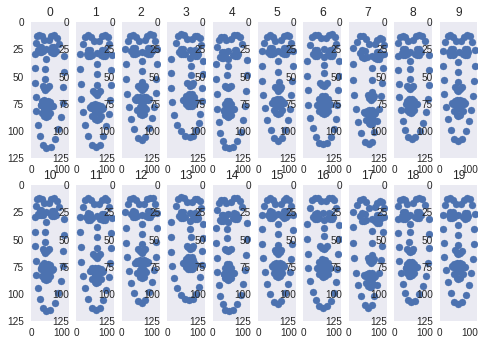

In [233]:
# reconstruct for testing landmarks
p,q = m_train.shape[1:3]

plot20 = np.reshape(np.zeros(20*p*q),(20,p,q))

for i in range(10):
    plot20[i,:,:] = m_test[i,:,:]
    plot20[10+i,:,:] = remat[i,:,:]
    

for i in range(20):
    ax= plt.subplot(2,10,i+1)
    tmpplot = plot20[i,:,:]
    #im=ax.scatter(tmpplot[:,0],1-tmpplot[:,1])
    im=ax.scatter(tmpplot[:,0],tmpplot[:,1])
    plt.xlim(0,125)
    plt.ylim(125,0)
    ax.grid(False)
    plt.title(i)

## 2. Plot the reconstruction error

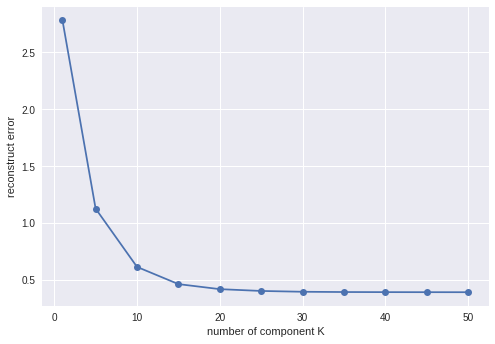

In [234]:
def m_total_re_error(K,X_train,X_test):

    n2,p,q = X_test.shape[0:3]
    
    # compare reconstruction error using HSV images
    


    _,_,test_1 = m_recons(K,X_train,X_test)
    """
    test_img = np.reshape(np.zeros(n2*p*p*3),(n2,p,p,3))
    for i in range(2):
         test_img[:,:,:,i] = orgin_img[:,:,:,i]
    test_img[:,:,:,2] = test_1[:,:,:]
    for i in range(n2):
        orgin_img[i,:,:,:] = hsv2rgb(orgin_img[i,:,:,:])
        test_img[i,:,:,:] = hsv2rgb(test_img[i,:,:,:])
    """
    orgin_img = X_test
    test_img = test_1[:,:,:]
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum(np.sqrt(np.sum((orgin_img[i,:,:]-test_img[i,:,:])**2,axis = 1)))/p
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(m_total_re_error(k,m_train,m_test))

    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.3 Combine two steps


In [0]:
# For training set
# first align the images by warping their landmarks into the mean position
from mywarper import warp
images = np.load('/content/drive/My Drive/Colab Notebooks/image.npy')

img_train, img_test, m_train, m_test = train_test_split(images,mats,test_size=0.2)
img_train.shape
n,p1 = img_train.shape[0:2]
n,p2,q2 = m_train.shape[0:3]
n2 = img_test.shape[0]
np.reshape(m_train,(n,-1))

tc = np.mean(np.reshape(m_train,(n,-1)),axis = 0)
ali_img = []
for i in range(n):
    a = warp(img_train[i],m_train[i],np.reshape(tc,(p2,q2)))
    #print(a)
    ali_img.append(a)
ali_train = np.array(ali_img)
# compute the eigen-faces from the aligned images
def appear_fun(K,X_train):
    
    # get eigen-faces
    X_train = X_train[:,:,:,2]
    n,p = X_train.shape[0:2]
    X = np.reshape(X_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=K)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(K,p,p))
    return pca.components_1
#X_train = ali_train  
appear_ev = appear_fun(50,ali_train)
appear_ev.shape
"""
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(ali_img1[i])
    ax.grid(False)
    plt.title(i)
plt.figure()
for i in range(10):
    ax= plt.subplot(2,5,i+1)
    im=ax.imshow(img_train[i])
    ax.grid(False)
    plt.title(i)
"""
# For testing part
# i) project its landmarks to the top 10 eigen-warpings, you get the reconstructed landmarks. 
# (here you lose a bit of geometric precision of reconstruction).
# remat (200*68*2)
_,_,remat = m_recons(10,m_train, m_test)
remat.shape
#ii) Warp the face image to the mean position and then project to the top k (say K=50) eigen-faces, 
#you get the reconstructed image at mean position (here you further lose a bit of appearance accuracy).
# recons_testali.shape 200*128*128

train_mean = np.reshape(np.mean(np.reshape(m_train,(n,-1)),axis = 0),(p2,q2))
img_train_mean = np.mean(np.reshape(img_train[:,:,:,2],(n,-1)),axis = 0)
test_ali = []
for i in range(n2):
    a = warp(img_test[i],m_test[i],train_mean)
    test_ali.append(a)
ali_test = np.array(test_ali)
ali_test1 = ali_test[:,:,:,2]
img_train_mean.shape

_,recons_testali = recons(50,ali_train,ali_test)
recons_testali = np.reshape(recons_testali,(n2,p1,p1,1))
# iii) Warp the reconstructed faces in step ii) to the positions reconstructed in step i). 
# recons_face 200*128*128*1
recons_face = []
for i in range(n2):
    a = warp(recons_testali[i],train_mean,remat[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(n2,p1,p1))

### Plot 20 reconstructed faces and their corresponding original faces. 

### Plot the reconstruction errors per pixel against the number of eigen-faces K = 1, 5, 10, 15, ..., 50.

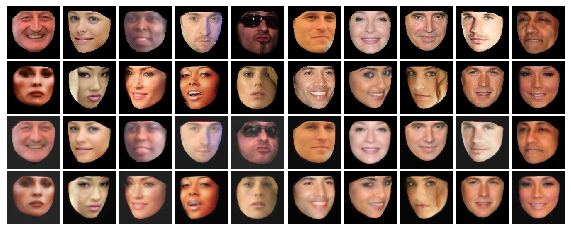

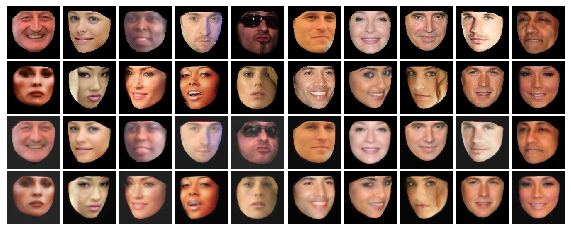

In [278]:
orginal_20 = img_test[0:20,:,:,:]
recon3_20 = np.reshape(np.zeros(20*p1*p1*3),(20,p1,p1,3))
for i in range(2):
  recon3_20[:,:,:,i] = orginal_20[:,:,:,i]
recon3_20[:,:,:,2] = recons_face[0:20,:,:]

plot20 = np.reshape(np.zeros(40*p1*p1*3),(40,p1,p1,3))
for i in range(20):
    plot20[i,:,:,:] = hsv2rgb(orginal_20[i,:,:,:])
    plot20[20+i,:,:,:] = hsv2rgb(recon3_20[i,:,:,:])
    # rgb must in 0-1 range
    #plot20[10+i,:,:,:] = scale_rgb(plot20[10+i,:,:,:])
    
plot(plot20,4,10,3,128,128)

1
5
10
15
20
25
30
35
40
45
50


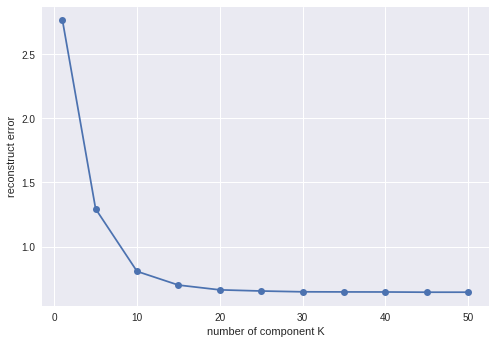

In [328]:
def re_error(img_train, img_test, m_train, m_test,K):
    n,p1 = img_train.shape[0:2]
    n,p2,q2 = m_train.shape[0:3]
    n2 = img_test.shape[0]
    # i)
    _,_,remat = m_recons(K,m_train, m_test)
    # ii)
    train_mean = np.reshape(np.mean(np.reshape(m_train,(n,-1)),axis = 0),(p2,q2))
    img_train_mean = np.mean(np.reshape(img_train[:,:,:,2],(n,-1)),axis = 0)
    test_ali = []
    for i in range(n2):
        a = warp(img_test[i],m_test[i],train_mean)
        test_ali.append(a)
    ali_test = np.array(test_ali)
    ali_test1 = ali_test[:,:,:,2]
    img_train_mean.shape

    _,recons_testali = recons(50,ali_train,ali_test)
    recons_testali = np.reshape(recons_testali,(n2,p1,p1,1))
    # iii)
    recons_face = []
    for i in range(n2):
        a = warp(recons_testali[i],train_mean,remat[i])
        recons_face.append(a)
    recons_face = np.array(recons_face)
    recons_face = np.reshape(recons_face,(n2,p1,p1))
    
    # compare reconstruction error using HSV images with V channel
    ## compute error
    a = 0
    for i in range(n2):
        a += np.sum((img_test[:,:,:,2]-recons_face[:,:,:])**2)/(p1*p1)
    a = a/n2
    return(a)

K = np.array([1,5,10,15,20,25,30,35,40,45,50])
error_record = []
for k in K:
    error_record.append(re_error(img_train, img_test, m_train, m_test,k))
    print(k)
    error_record
plt.plot(K, error_record, '-o')
plt.xlabel("number of component K")
plt.ylabel("reconstruct error")
plt.show()

# 2.1.4 Synthesize random faces


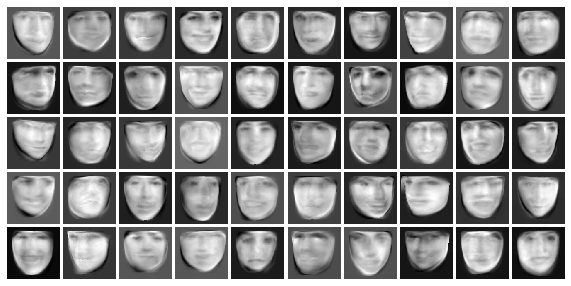

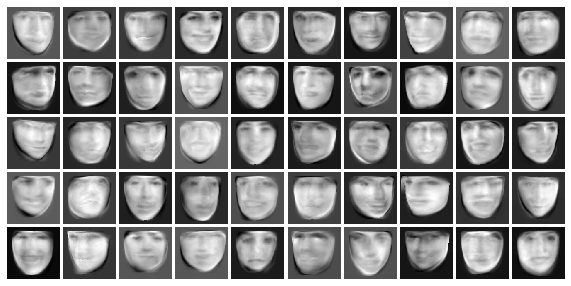

In [327]:
# randomly choose bi
#img_train, img_test, m_train, m_test
def random_bi(img_train, img_test, m_train, m_test,num,k1,k2):
    #num = 50
    #k1 = 50
    #k2 = 10
    n,p1 = img_train.shape[0:2]
    n,p2,q2 = m_train.shape[0:3]
    n2 = img_test.shape[0]


    X_train = img_train[:,:,:,2]
    X = np.reshape(X_train,(n,-1))
    m = np.mean(X, axis=0)
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=k1)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_1 = np.reshape(pca.components_,(k1,p1*p1))
    cov1 = np.diag(pca.explained_variance_)
    b1 = np.random.multivariate_normal(np.zeros(k1), cov1, num)
    I1 = np.reshape(np.zeros(num*p1*p1),(num,-1))
    for i in range(num):
        I1[i,:] = np.reshape(b1[i],(1,k1)).dot(pca.components_1) + np.mean(X, axis=0)
    I1 = np.reshape(I1,(num,p1,p1,1))

    X = np.reshape(m_train,(n,-1))
    X_centered = X - np.mean(X, axis=0)
    pca = decomposition.PCA(n_components=k2)
    X_transformed = pca.fit_transform(X_centered)
    pca.components_2 = np.reshape(pca.components_,(k2,p2*q2))
    cov2 = np.diag(pca.explained_variance_)
    b2 = np.random.multivariate_normal(np.zeros(k2), cov2, num)
    I2 = np.reshape(np.zeros(num*p2*q2),(num,-1))
    for i in range(num):
        I2[i,:] = np.reshape(b2[i],(1,k2)).dot(pca.components_2) + np.mean(X, axis=0)
    I2 = np.reshape(I2,(num,p2,q2))
    m = np.reshape(np.mean(X, axis=0),(p2,q2))
    return (m,I1,I2)
num = 50
k1 = 50
k2 = 10
m_landmark,I1,I2 = random_bi(img_train, img_test, m_train, m_test,num,k1,k2)
recons_face = []
for i in range(num):
    a = warp(I1[i],m_landmark,I2[i])
    recons_face.append(a)
recons_face = np.array(recons_face)
recons_face = np.reshape(recons_face,(num,p1,p1,1))

    
plot(recons_face,5,10,1,128,128)

# 2.2 Autoencoder: a non-linear method

